In [1]:
import os
import sys
import json

import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torch.optim as optim
from tqdm import tqdm

from MedMamba import VSSM as medmamba # import model

import utils
from config import Config

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

train_dataset, validate_dataset, test_dataset = utils.load_dataset(Config.DATA_DIR)
print("using {} images for training, {} images for validation.".format(len(train_dataset), len(validate_dataset)))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=Config.NUM_WORKER)
validate_loader = torch.utils.data.DataLoader(validate_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=Config.NUM_WORKER)

using cuda:0 device.
using 3150 images for training, 675 images for validation.


In [3]:
net = medmamba(num_classes=Config.NUM_CLASS)
net.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

epochs = Config.EPOCH
best_acc = 0.0
save_path = './Net.pth'
train_steps = len(train_loader)
for epoch in range(epochs):
    # train
    net.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, file=sys.stdout)
    for step, data in enumerate(train_bar):
        images, labels = data
        optimizer.zero_grad()
        outputs = net(images.to(device))
        loss = loss_function(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                 epochs,
                                                                 loss)

    # validate
    net.eval()
    acc = 0.0  # accumulate accurate number / epoch
    with torch.no_grad():
        val_bar = tqdm(validate_loader, file=sys.stdout)
        for val_data in val_bar:
            val_images, val_labels = val_data
            outputs = net(val_images.to(device))
            predict_y = torch.max(outputs, dim=1)[1]
            acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

    val_accurate = acc / len(validate_dataset)
    print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
          (epoch + 1, running_loss / train_steps, val_accurate))

    if val_accurate > best_acc:
        best_acc = val_accurate
        torch.save(net.state_dict(), save_path)

print('Finished Training')

100%|██████████| 22/22 [00:01<00:00, 20.33it/s]
[epoch 1] train_loss: 0.437  val_accuracy: 0.639
100%|██████████| 22/22 [00:01<00:00, 20.28it/s]
[epoch 2] train_loss: 0.207  val_accuracy: 0.804
100%|██████████| 22/22 [00:01<00:00, 20.83it/s]
[epoch 3] train_loss: 0.137  val_accuracy: 0.720
100%|██████████| 22/22 [00:01<00:00, 21.07it/s]
[epoch 4] train_loss: 0.111  val_accuracy: 0.701
100%|██████████| 22/22 [00:01<00:00, 21.07it/s]
[epoch 5] train_loss: 0.061  val_accuracy: 0.945
100%|██████████| 22/22 [00:01<00:00, 21.32it/s]
[epoch 6] train_loss: 0.018  val_accuracy: 0.972
100%|██████████| 22/22 [00:01<00:00, 20.52it/s]
[epoch 7] train_loss: 0.022  val_accuracy: 0.650
100%|██████████| 22/22 [00:01<00:00, 21.02it/s]
[epoch 8] train_loss: 0.083  val_accuracy: 0.926
100%|██████████| 22/22 [00:01<00:00, 20.87it/s]
[epoch 9] train_loss: 0.045  val_accuracy: 0.883
100%|██████████| 22/22 [00:01<00:00, 20.64it/s]
[epoch 10] train_loss: 0.036  val_accuracy: 0.939
100%|██████████| 22/22 [00:01

100%|██████████| 22/22 [00:01<00:00, 20.64it/s]


[[221.   4.   0.]
 [  2. 209.   9.]
 [  2.  12. 216.]]


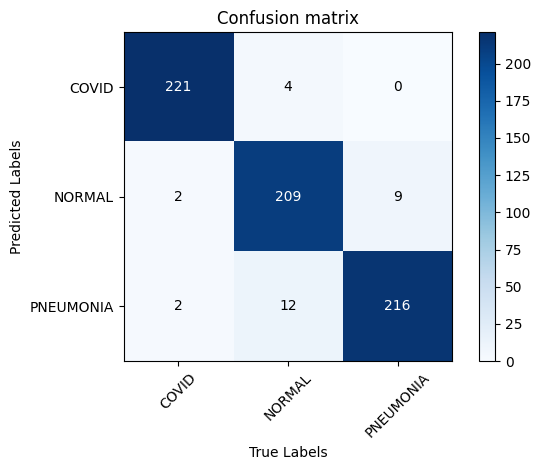

the model accuracy is  0.957037037037037
+-----------+-----------+--------+-------------+
|           | Precision | Recall | Specificity |
+-----------+-----------+--------+-------------+
|   COVID   |   0.982   | 0.982  |    0.991    |
|   NORMAL  |    0.95   | 0.929  |    0.976    |
| PNEUMONIA |   0.939   |  0.96  |    0.969    |
+-----------+-----------+--------+-------------+


In [4]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=Config.NUM_WORKER)

net = medmamba(num_classes=Config.NUM_CLASS)
# load pretrain weights
model_weight_path = "./Net.pth"
assert os.path.exists(model_weight_path), "cannot find {} file".format(model_weight_path)
net.load_state_dict(torch.load(model_weight_path, map_location=device))
net.to(device)

# read class_indict
json_label_path = './class_indices.json'
assert os.path.exists(json_label_path), "cannot find {} file".format(json_label_path)
json_file = open(json_label_path, 'r')
class_indict = json.load(json_file)

labels = [label for _, label in class_indict.items()]
confusion = utils.ConfusionMatrix(num_classes=Config.NUM_CLASS, labels=labels)
net.eval()
with torch.no_grad():
    for val_data in tqdm(test_loader):
        val_images, val_labels = val_data
        outputs = net(val_images.to(device))
        outputs = torch.softmax(outputs, dim=1)
        outputs = torch.argmax(outputs, dim=1)
        confusion.update(outputs.to("cpu").numpy(), val_labels.to("cpu").numpy())
confusion.plot()
confusion.summary()